Importing the **numpy**, **pandas**, **seaborn** and **matplotlib** libraries, which provide tools for exploratory data analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.formula.api as smf

I load the Steam sales CSV into a DataFrame, normalize and convert **Release Date** in-place to proper `datetime` (ISO `yyyy-mm-dd`), and assert that no dates failed conversion. I clean **#Reviews** by removing commas and trailing `.0`, then convert to **int**. I also clean **Rating** by stripping trailing `.0` and convert it to **int**.


In [2]:
steam_sales_path= "../data/steam_sales.csv"
steam_df = pd.read_csv(steam_sales_path)

# Convert Release Date to datetime for easier time-based analysis (sorting, plotting, extracting year/month)
def normalize_date_format(date_str):
    if pd.isna(date_str):
        return None
    
    # Pattern 1: Month day, year (e.g., "Jun 16, 2025")
    pattern1 = r'^([A-Za-z]{3}) (\d{1,2}), (\d{4})$'
    # Pattern 2: Day month, year (e.g., "25 Jun, 2024")
    pattern2 = r'^(\d{1,2}) ([A-Za-z]{3}), (\d{4})$'
    
    if re.match(pattern1, date_str):
        m = re.match(pattern1, date_str)
        # Reorder to "16 Jun, 2025"
        return f"{m.group(2)} {m.group(1)}, {m.group(3)}"
    elif re.match(pattern2, date_str):
        return date_str  # already correct
    else:
        return None  # non-date strings (like "Coming Soon")

# Apply normalization, then convert back into datetime (overwriting the same column)
steam_df['Release Date'] = steam_df['Release Date'].apply(normalize_date_format)
steam_df['Release Date'] = pd.to_datetime(steam_df['Release Date'], format="%d %b, %Y", errors='coerce')

# Ensure all dates are parsed correctly
assert steam_df['Release Date'].isna().sum() == 0, "Not all dates converted successfully."

steam_df['#Reviews'] = (
    steam_df['#Reviews']
    .str.replace(',', '', regex=False)   # remove commas
    .str.replace(r'\.0$', '', regex=True) # remove trailing ".0"
    .astype(int)                         # convert to int
)

steam_df['Rating'] = (
    steam_df['Rating']
    .astype(str)
    .str.replace(r'\.0$', '', regex=True)  # remove trailing ".0"
    .astype(int)                         # convert to float
)


In [3]:
steam_df.head()

,Game Name,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Fetched At
0,PEAK,7,77683,-38.0,4.64,7.49,2025-06-16,1,0,0,2025-08-11 00:00
1,Cyberpunk 2077,7,772574,-65.0,20.99,59.99,2020-12-09,1,0,1,2025-08-11 00:00
2,Rust,7,1038433,-50.0,19.99,39.99,2018-02-08,1,0,1,2025-08-11 00:00
3,Microsoft Flight Simulator (2020) 40th Anniver...,5,63905,-60.0,27.99,69.99,2020-08-17,1,0,0,2025-08-11 00:00
4,Sid Meier's Civilization VII,4,34643,-30.0,48.99,69.99,2025-02-10,1,1,1,2025-08-11 00:00


In [4]:
# Quick overview
print("Dataset info:")
print(steam_df.info())

print("\nFirst 5 rows:")
display(steam_df.head())

print(f"\nShape of dataset: {steam_df.shape}")
print("\nSummary statistics:")
display(steam_df.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543 entries, 0 to 2542
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Game Name           2543 non-null   object        
 1   Rating              2543 non-null   int64         
 2   #Reviews            2543 non-null   int64         
 3   Discount%           2543 non-null   float64       
 4   Price (€)           2543 non-null   float64       
 5   Original Price (€)  2543 non-null   float64       
 6   Release Date        2543 non-null   datetime64[ns]
 7   Windows             2543 non-null   int64         
 8   Linux               2543 non-null   int64         
 9   MacOS               2543 non-null   int64         
 10  Fetched At          2543 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 218.7+ KB
None

First 5 rows:


,Game Name,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Fetched At
0,PEAK,7,77683,-38.0,4.64,7.49,2025-06-16,1,0,0,2025-08-11 00:00
1,Cyberpunk 2077,7,772574,-65.0,20.99,59.99,2020-12-09,1,0,1,2025-08-11 00:00
2,Rust,7,1038433,-50.0,19.99,39.99,2018-02-08,1,0,1,2025-08-11 00:00
3,Microsoft Flight Simulator (2020) 40th Anniver...,5,63905,-60.0,27.99,69.99,2020-08-17,1,0,0,2025-08-11 00:00
4,Sid Meier's Civilization VII,4,34643,-30.0,48.99,69.99,2025-02-10,1,1,1,2025-08-11 00:00



Shape of dataset: (2543, 11)

Summary statistics:


,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS
count,2543.000000,2.543000e+03,2543.000000,2543.000000,2543.000000,2543,2543.000000,2543.000000,2543.000000
mean,6.433346,1.845428e+04,-51.055053,12.742993,27.949866,2021-12-07 10:56:17.742823424,0.996068,0.185608,0.281950
min,3.000000,1.000000e+01,-95.000000,0.530000,2.990000,2006-11-29 00:00:00,0.000000,0.000000,0.000000
25%,5.000000,1.013500e+03,-74.500000,5.990000,15.990000,2020-01-12 12:00:00,1.000000,0.000000,0.000000
50%,7.000000,3.344000e+03,-50.000000,9.990000,24.990000,2023-03-06 00:00:00,1.000000,0.000000,0.000000
75%,7.000000,1.391550e+04,-30.000000,16.990000,39.990000,2024-10-18 12:00:00,1.000000,0.000000,1.000000
max,8.000000,1.038433e+06,-10.000000,64.990000,99.990000,2025-09-28 00:00:00,1.000000,1.000000,1.000000
std,1.279637,5.650066e+04,23.132706,8.990933,15.762686,NaN,0.062597,0.388866,0.450038


Getting the top 5 games by platform, this is sorted by rating for each platform.

In [5]:
platforms = ['Windows', 'Linux', 'MacOS']
top_n = 5

for plat in platforms:
    print(f"Top {top_n} games for {plat}:")
    display(
        steam_df[steam_df[plat]==1]
        .sort_values('Rating', ascending=False)
        .head(top_n)
        [['Game Name','Rating','Price (€)','Discount%']]
    )

Top 5 games for Windows:


,Game Name,Rating,Price (€),Discount%
2128,Arctic Eggs,8,4.99,-50.0
284,ROUNDS,8,2.74,-50.0
1903,Human Fall Flat,8,5.99,-70.0
538,SOMA,8,8.99,-70.0
935,FlyKnight,8,4.79,-20.0


Top 5 games for Linux:


,Game Name,Rating,Price (€),Discount%
1021,Astral Ascent,8,12.49,-50.0
415,Is This Seat Taken?,8,8.99,-10.0
1080,Danganronpa: Trigger Happy Havoc,8,13.99,-30.0
1075,The Jackbox Party Pack 4,8,11.24,-55.0
1480,Dead Cells,8,10.99,-50.0


Top 5 games for MacOS:


,Game Name,Rating,Price (€),Discount%
1784,Beastieball,8,16.99,-15.0
1269,The Henry Stickmin Collection,8,5.99,-60.0
2022,NEEDY STREAMER OVERLOAD,8,7.99,-50.0
737,Baldur's Gate 3,8,44.99,-25.0
802,Slay the Spire,8,8.49,-66.0


Next we want to visualize how many games are available for each platform.

/var/folders/th/ggxxzbv16pvd12pt0k2h8rtr0000gn/T/ipykernel_52632/118175025.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_counts.index, y=platform_counts.values, palette='viridis')


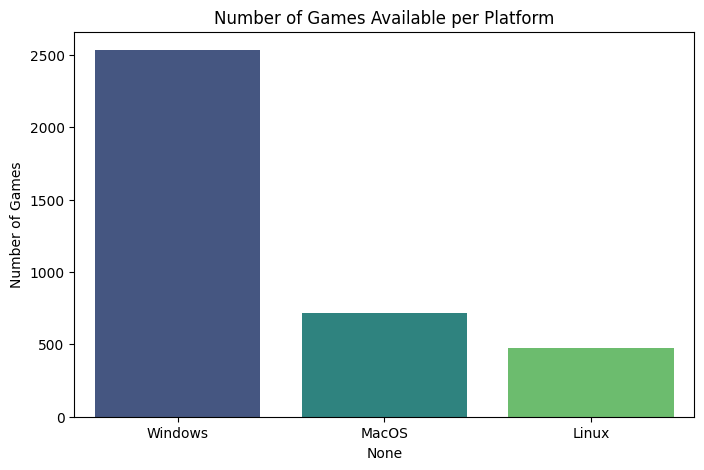

In [6]:
platform_counts = steam_df[['Windows', 'Linux', 'MacOS']].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=platform_counts.index, y=platform_counts.values, palette='viridis')
plt.title('Number of Games Available per Platform')
plt.ylabel('Number of Games')
plt.show()

Next we have the **discount** distribution for all games. This is useful for knowing typical discounts and their frequency. 

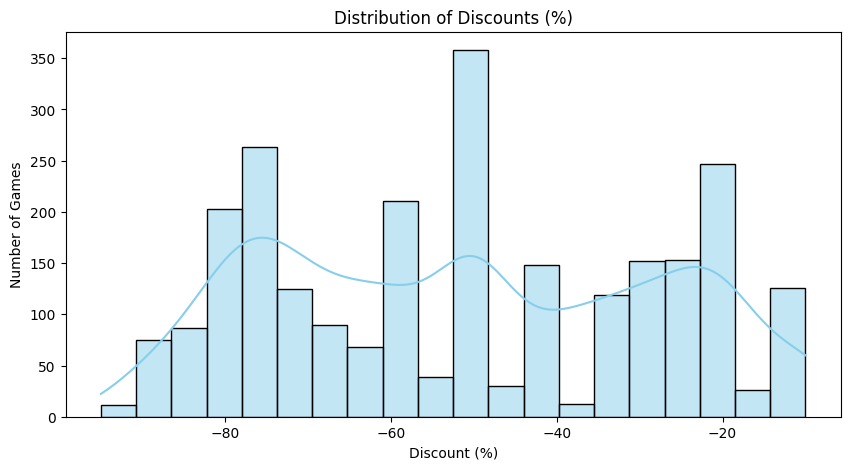

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(steam_df['Discount%'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Discounts (%)')
plt.xlabel('Discount (%)')
plt.ylabel('Number of Games')
plt.show()


Now we want to see how **discounts** are distributed across **platforms**. This helps us see if certain **platforms** are discounted earlier than others.

/var/folders/th/ggxxzbv16pvd12pt0k2h8rtr0000gn/T/ipykernel_52632/1687470703.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(avg_discount.keys()), y=list(avg_discount.values()), palette='coolwarm')


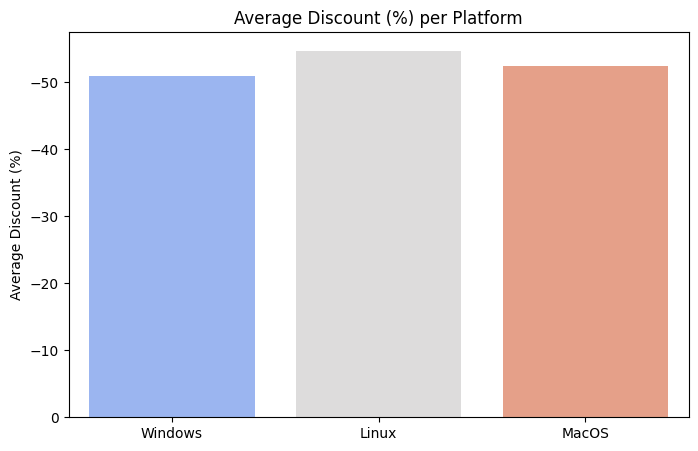

In [8]:
avg_discount = {plat: steam_df[steam_df[plat]==1]['Discount%'].mean() for plat in platforms}
plt.figure(figsize=(8,5))
sns.barplot(x=list(avg_discount.keys()), y=list(avg_discount.values()), palette='coolwarm')
plt.title('Average Discount (%) per Platform')
plt.ylabel('Average Discount (%)')
plt.gca().invert_yaxis()
plt.show()

### Visualizing Game Release Distribution by Year

This code converts release dates to a datetime format, extracts the release year, and counts how many games were released each year.  
The results are displayed as a bar chart, providing a clear visualization of how the number of Steam game releases has changed over time and highlighting periods of growth or decline in publishing activity.

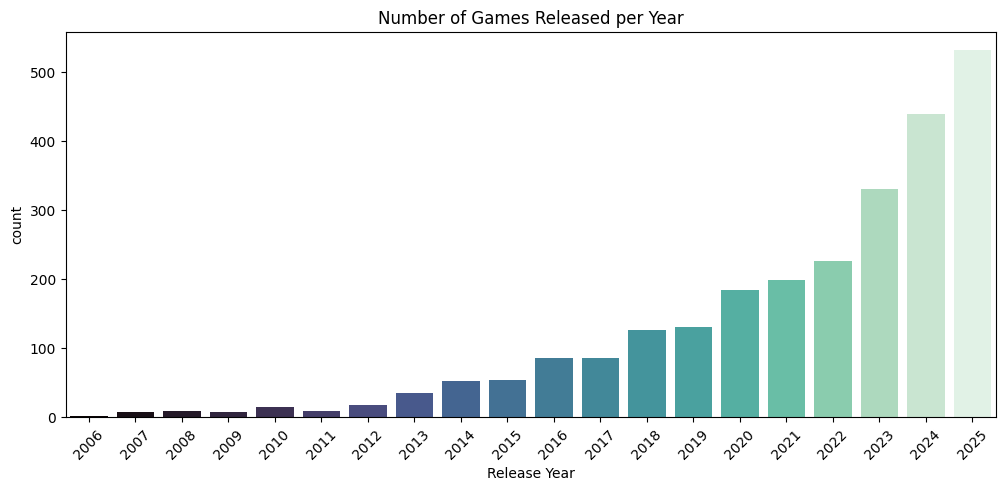

In [9]:
steam_df['Release Year'] = steam_df['Release Date'].dt.year

# For plotting, use only rows with a year and cast to plain int
plot_df = steam_df[steam_df['Release Year'].notna()].copy()
plot_df['ReleaseYearInt'] = plot_df['Release Year'].astype(int)

order = sorted(plot_df['ReleaseYearInt'].unique())

plt.figure(figsize=(12,5))
sns.countplot(
    x='ReleaseYearInt',
    hue='ReleaseYearInt',          # to use the palette w/o deprecation warning
    data=plot_df,
    palette='mako',
    order=order,
    legend=False
)
plt.title('Number of Games Released per Year')
plt.xlabel('Release Year')
plt.xticks(rotation=45)
plt.show()


### Analysis of Game Release Distribution (2006–2025)

The distribution of releases is uneven, reflecting the growth of Steam as a publishing platform rather than the entire gaming industry. 

Between **2006 and 2014**, the dataset includes very few titles per year, suggesting limited adoption of Steam by major publishers and an incomplete sample of total releases. These early values should be treated cautiously, as they are not representative of the market.

From **2015 to 2019**, release counts rise steadily, marking the transition to a broader and more open distribution era. This period aligns with the introduction of Steam Direct (2017), which reduced publishing barriers and led to a gradual increase in indie releases.

After **2020**, there is a sharp acceleration in new titles. The expansion corresponds with the pandemic-driven growth in digital entertainment, easier access to development tools, and continued diversification of the platform. 

Overall, meaningful trend analysis should focus on **2015–2025**, when data density and platform maturity make the sample more reliable for examining price, genre, and rating trends.


### Correlation Heatmap for Numerical

This heatmap shows us the correlation between every numerical field.

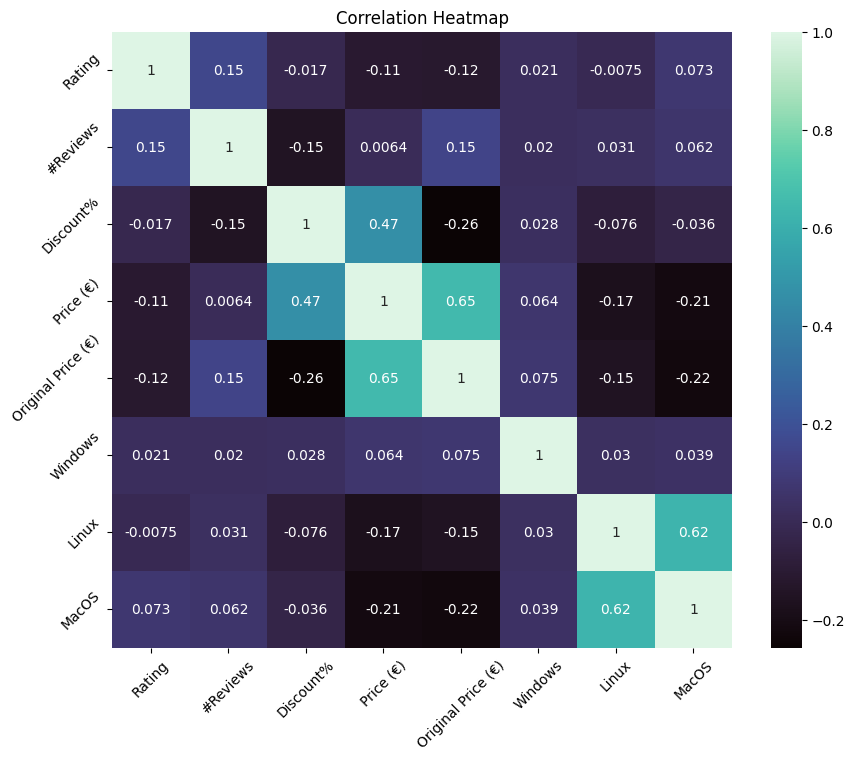

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(
    steam_df[['Rating','#Reviews','Discount%','Price (€)','Original Price (€)','Windows','Linux','MacOS']].corr(),
    annot=True,
    cmap='mako'
)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)   # Keep y-axis labels horizontal (optional)
plt.show()


### Descriptive Statistics Summary

The dataset contains 2,543 entries with numerical data available for ratings, discounts, prices, and platform availability. On average, games have a rating of around 6.4 out of 8 and an average discount of about 51%, suggesting that most titles are often sold below their original price. The mean price after discounts is €12.74, compared to an average original price of €27.95, indicating a significant reduction in selling prices across the dataset. Most games appear to support Windows, while Linux and macOS availability are much lower.

### Note on Date Column

The release date column was not included in the summary because it is stored as a non-numeric datatype (`object`) and therefore excluded from numerical descriptive analysis.

In [11]:
steam_df.dtypes

Game Name                     object
Rating                         int64
#Reviews                       int64
Discount%                    float64
Price (€)                    float64
Original Price (€)           float64
Release Date          datetime64[ns]
Windows                        int64
Linux                          int64
MacOS                          int64
Fetched At                    object
Release Year                   int32
dtype: object

In [12]:
steam_df.describe()

,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Release Year
count,2543.000000,2.543000e+03,2543.000000,2543.000000,2543.000000,2543,2543.000000,2543.000000,2543.000000,2543.000000
mean,6.433346,1.845428e+04,-51.055053,12.742993,27.949866,2021-12-07 10:56:17.742823424,0.996068,0.185608,0.281950,2021.417617
min,3.000000,1.000000e+01,-95.000000,0.530000,2.990000,2006-11-29 00:00:00,0.000000,0.000000,0.000000,2006.000000
25%,5.000000,1.013500e+03,-74.500000,5.990000,15.990000,2020-01-12 12:00:00,1.000000,0.000000,0.000000,2020.000000
50%,7.000000,3.344000e+03,-50.000000,9.990000,24.990000,2023-03-06 00:00:00,1.000000,0.000000,0.000000,2023.000000
75%,7.000000,1.391550e+04,-30.000000,16.990000,39.990000,2024-10-18 12:00:00,1.000000,0.000000,1.000000,2024.000000
max,8.000000,1.038433e+06,-10.000000,64.990000,99.990000,2025-09-28 00:00:00,1.000000,1.000000,1.000000,2025.000000
std,1.279637,5.650066e+04,23.132706,8.990933,15.762686,NaN,0.062597,0.388866,0.450038,3.651007


### Creating Price and Year Categories for Cross-Tabulation

This section categorizes games by both **price range** and **release year interval** to explore how pricing patterns have evolved over time.

1. **Extracting Release Year**  
   The `Release Year` column is created by converting the `Release Date` into its numeric year component. This allows grouping and comparison by year.

2. **Defining Price Ranges**  
   Games are divided into price brackets (`0–30`, `30–40`, `40–50`, `50–60`, `60+`) using `pd.cut()`.  
   This simplifies the continuous price data into discrete categories suitable for comparison.

3. **Defining Year Intervals**  
   The `Release Year` values are grouped into 5-year intervals starting from 2000 (e.g., `2000–2004`, `2005–2009`, …).  
   This reduces year-to-year variability and highlights long-term trends.

4. **Cross-Tabulation**  
   A cross-tab (`pd.crosstab`) is created to count the number of games within each **price range** and **year interval** combination.  
   The resulting table shows how the distribution of game prices has changed across different release periods.


In [13]:
price_bins = [0, 30, 40, 50, 60, float('inf')]
price_labels = ['0-30', '30-40', '40-50', '50-60', '60+']

steam_df['Price Range'] = pd.cut(steam_df['Original Price (€)'], bins=price_bins, labels=price_labels, right=False)

year_bins = [2000, 2005, 2010, 2015, 2020, 2025, 2030]
year_labels = ['2000–2004', '2005–2009', '2010–2014', '2015–2019', '2020–2024', '2025+']

steam_df['Year Interval'] = pd.cut(steam_df['Release Year'], bins=year_bins, labels=year_labels, right=False)

cross_tab = pd.crosstab(steam_df['Price Range'], steam_df['Year Interval'])
cross_tab

Year Interval,2005–2009,2010–2014,2015–2019,2020–2024,2025+
Price Range,,,,,
0-30,24,106,341,884,427
30-40,1,10,73,243,39
40-50,0,6,28,120,27
50-60,0,4,33,98,17
60+,0,0,6,34,22


### Cross-Tabulation of Price Range by Release Year Interval

This table shows the distribution of games across different price categories and release periods.  
Lower-priced games (€0–30) dominate all intervals, especially from **2020–2024**, indicating a strong market presence of discounted or lower-cost titles in recent years.  
Mid-range prices (€30–60) appear less frequently, suggesting that fewer games are released at higher price points on Steam.  
The gradual increase in counts across all categories after 2015 reflects the platform’s growth and a larger overall volume of releases in the last decade.  
Further analysis of the **price distribution over time** is needed to determine whether these trends are driven by changing market strategies, consumer demand, or shifts in the types of games being published.


### Filtering Games Released Before 2015

This step filters the dataset to include only games released before the year 2015.  
By displaying their names, release dates, original prices, and ratings, it provides a clearer view of early Steam titles and allows comparison of pricing and quality trends before the platform’s major expansion period.


In [14]:
games_before_2015 = steam_df[steam_df['Release Date'].dt.year < 2015]
games_before_2015[['Game Name', 'Release Date', 'Original Price (€)', 'Rating']]


,Game Name,Release Date,Original Price (€),Rating
17,Europa Universalis IV,2013-08-13,49.99,7
70,Call of Duty®: Black Ops II,2012-11-12,59.99,7
97,Fallout: New Vegas,2010-10-21,9.99,8
103,Far Cry® 4,2014-11-17,29.99,7
129,IL-2 Sturmovik: Battle of Stalingrad,2014-10-22,48.99,5
...,...,...,...,...
2470,DYNASTY WARRIORS 8: Xtreme Legends Complete Ed...,2014-05-13,49.99,7
2479,Silent Hill Homecoming,2008-11-06,39.99,4
2486,Castlevania: Lords of Shadow 2,2014-02-25,39.99,5
2491,FINAL FANTASY® XIII-2,2014-12-11,19.99,4


This step filters the dataset to include only games released before the year 2015.  
By displaying their names, release dates, original prices, and ratings, it provides a clearer view of early Steam titles and allows comparison of pricing and quality trends before the platform’s major expansion period.  
While this list offered useful insight into early releases, a **visualization** was needed to better understand how game releases and pricing evolved over time.


In [15]:
# Load data
df_inflation = pd.read_csv('../data/all_items_hicp.csv')
MAX_YEAR = df_inflation['Year'].max()
# Filter to games released in 2015 or later (earlier years have very little data)
print(f"Total games before filtering: {len(steam_df)}")
df_games = steam_df[(steam_df['Release Year'] >= 2015) & (steam_df['Release Year'] <= MAX_YEAR)].copy()
print(f"Total games after filtering (2015+): {len(df_games)}")

print("\nGames per year:")
print(df_games['Release Year'].value_counts().sort_index())

# Prepare inflation data (assuming you'll use European Union column)
df_inflation = df_inflation.rename(columns={'European Union': 'HICP'})

# Merge with inflation data
df_games = df_games.merge(df_inflation[['Year', 'HICP']], 
                          left_on='Release Year', 
                          right_on='Year', 
                          how='left')

# Handle missing inflation data (games outside the inflation data range)
# Option 1: Use nearest available year
df_games['HICP'] = df_games.groupby('Release Year')['HICP'].transform(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
)

Total games before filtering: 2543
Total games after filtering (2015+): 1860

Games per year:
Release Year
2015     53
2016     86
2017     85
2018    126
2019    131
2020    184
2021    198
2022    226
2023    331
2024    440
Name: count, dtype: int64


/var/folders/th/ggxxzbv16pvd12pt0k2h8rtr0000gn/T/ipykernel_52632/391301918.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')


In [16]:
# Choose base year for adjustment

BASE_YEAR = 2024

# Get base year HICP
base_hicp = df_inflation[df_inflation['Year'] == BASE_YEAR]['HICP'].values[0]

# Calculate adjustment factor
df_games['adjustment_factor'] = base_hicp / df_games['HICP']

# Apply inflation adjustment to original price
# Remove € symbol and convert to float if needed
df_games['Original Price (€)'] = df_games['Original Price (€)'].astype(float)
df_games['adjusted_price'] = df_games['Original Price (€)'] * df_games['adjustment_factor']

print(f"Base year: {BASE_YEAR}, Base HICP: {base_hicp}")
print(f"Price adjustment example:")
df_games[['Game Name', 'Release Year', 'Original Price (€)', 
                'adjusted_price', 'HICP']].head(10)

Base year: 2024, Base HICP: 130.21
Price adjustment example:


,Game Name,Release Year,Original Price (€),adjusted_price,HICP
0,Cyberpunk 2077,2020,59.99,73.552711,106.20
1,Rust,2018,39.99,50.121262,103.89
2,Microsoft Flight Simulator (2020) 40th Anniver...,2020,69.99,85.813540,106.20
3,Age of Wonders 4,2023,49.99,51.289874,126.91
4,Sea of Thieves: 2025 Edition,2020,39.99,49.031054,106.20
5,Hearts of Iron IV,2024,49.99,49.990000,130.21
6,The Elder Scrolls® Online,2017,19.99,25.528618,101.96
7,Cyberpunk 2077: Phantom Liberty,2023,29.99,30.769820,126.91
8,Fallout 76,2020,39.99,49.031054,106.20
9,Stellaris,2016,39.99,51.941126,100.25


In [17]:
df_inflation

,Year,HICP,Germany,United States
0,2004,81.00,83.8,79.60
1,2005,82.75,85.5,82.54
2,2006,84.58,87.0,85.16
3,2007,86.55,89.0,87.40
4,2008,89.72,91.4,91.22
5,2009,90.60,91.6,90.46
6,2010,92.49,92.7,92.66
7,2011,95.36,95.0,96.20
8,2012,97.88,97.0,98.23
9,2013,99.35,98.6,99.46


In [18]:
# Calculate percentiles
p25 = df_games['adjusted_price'].quantile(0.25)
p50 = df_games['adjusted_price'].quantile(0.50)
p75 = df_games['adjusted_price'].quantile(0.75)

print(f"Percentile thresholds:")
print(f"25th percentile: €{p25:.2f}")
print(f"50th percentile: €{p50:.2f}")
print(f"75th percentile: €{p75:.2f}")

# Create price tiers using pd.cut
df_games['price_tier'] = pd.cut(df_games['adjusted_price'],
                                 bins=[0, p25, p50, p75, np.inf],
                                 labels=['Budget', 'Mid-Low', 'Mid-High', 'Premium'],
                                 include_lowest=True)

# Check tier distribution
print("\nPrice tier distribution:")
print(df_games['price_tier'].value_counts().sort_index())

Percentile thresholds:
25th percentile: €20.19
50th percentile: €29.88
75th percentile: €43.64

Price tier distribution:
price_tier
Budget      465
Mid-Low     465
Mid-High    485
Premium     445
Name: count, dtype: int64


In [19]:
df_games.dtypes

Game Name                     object
Rating                         int64
#Reviews                       int64
Discount%                    float64
Price (€)                    float64
Original Price (€)           float64
Release Date          datetime64[ns]
Windows                        int64
Linux                          int64
MacOS                          int64
Fetched At                    object
Release Year                   int32
Price Range                 category
Year Interval               category
Year                           int64
HICP                         float64
adjustment_factor            float64
adjusted_price               float64
price_tier                  category
dtype: object

In [20]:
labels = ['Budget', 'Mid-Low', 'Mid-High', 'Premium']

df_games['adjusted_price'] = pd.to_numeric(df_games['adjusted_price'], errors='coerce')

df_games['yearly_tier'] = (
    df_games.groupby('Release Year', group_keys=False)['adjusted_price']
            .apply(lambda s: pd.cut(
                s.rank(method='first', pct=True),  # rank to 0..1 within the year
                bins=[0, .25, .50, .75, 1.0],
                labels=labels,
                include_lowest=True
            ).astype('string'))
)

# Compare overall vs yearly tiers
print("\nYearly tier distribution:")
print(df_games['yearly_tier'].value_counts().sort_index())

# Example: Compare tiers for games from different years
print("\nExample: Same price, different years, different yearly tiers:")
df_games[['Game Name', 'Release Year', 'Original Price (€)', 'adjusted_price', 
                'price_tier', 'yearly_tier']].sample(10)


Yearly tier distribution:
yearly_tier
Budget      461
Mid-High    463
Mid-Low     467
Premium     469
Name: count, dtype: Int64

Example: Same price, different years, different yearly tiers:


,Game Name,Release Year,Original Price (€),adjusted_price,price_tier,yearly_tier
1132,Crime Scene Cleaner,2024,20.72,20.720000,Mid-Low,Mid-Low
920,BLACKTAIL,2022,29.99,32.727103,Mid-High,Mid-High
1388,The Talos Principle 2,2023,29.99,30.769820,Mid-High,Mid-High
804,Demon Slayer -Kimetsu no Yaiba- The Hinokami C...,2021,59.99,71.479666,Premium,Premium
1442,Cult of the Lamb: Heretic Pack,2023,4.99,5.119753,Budget,Budget
1310,Laundry Store Simulator,2024,9.99,9.990000,Budget,Budget
803,The Jackbox Party Pack 5,2018,29.99,37.587813,Mid-High,Mid-High
20,Resident Evil Village,2021,39.99,47.649139,Premium,Mid-High
1118,Crusader Kings III: Tours & Tournaments,2023,24.99,25.639807,Mid-Low,Mid-Low
553,Kingdom Come: Deliverance Royal Edition,2019,39.99,49.393833,Premium,Mid-High


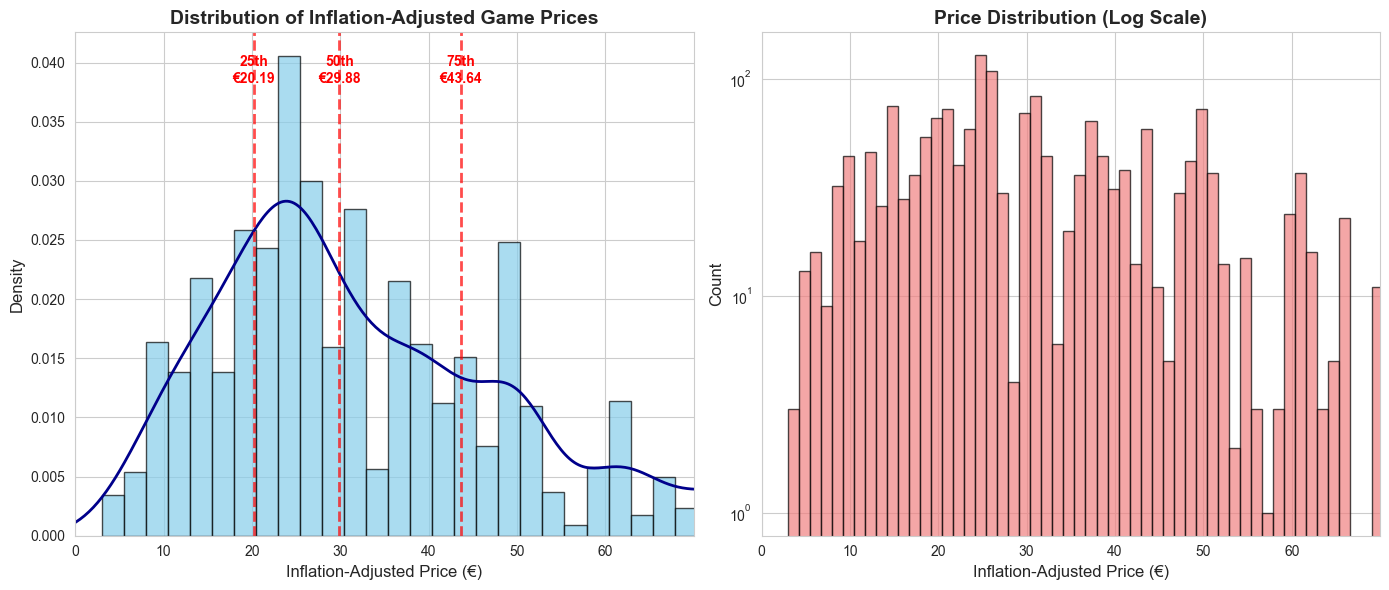

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Create histogram with KDE overlay
# HISTOGRAM: Shows the frequency distribution of prices in bins
# KDE (Kernel Density Estimate): Smooth curve that estimates the probability density
# KDE is useful for seeing the overall shape without the "choppiness" of histogram bars
plt.subplot(1, 2, 1)
plt.hist(df_games['adjusted_price'], bins=50, alpha=0.7, color='skyblue', 
         edgecolor='black', density=True)
df_games['adjusted_price'].plot(kind='kde', color='darkblue', linewidth=2)
plt.xlabel('Inflation-Adjusted Price (€)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Inflation-Adjusted Game Prices', fontsize=14, fontweight='bold')
plt.xlim(0, df_games['adjusted_price'].quantile(0.95))  # Limit to 95th percentile for clarity

# Add percentile lines
for q, label in [(0.25, '25th'), (0.50, '50th'), (0.75, '75th')]:
    val = df_games['adjusted_price'].quantile(q)
    plt.axvline(val, color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.text(val, plt.ylim()[1]*0.9, f'{label}\n€{val:.2f}', 
             ha='center', color='red', fontweight='bold')

plt.subplot(1, 2, 2)
# Log scale for better visibility of lower prices
plt.hist(df_games['adjusted_price'], bins=100, alpha=0.7, color='lightcoral', 
         edgecolor='black')
plt.xlabel('Inflation-Adjusted Price (€)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Price Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.xlim(0, df_games['adjusted_price'].quantile(0.95))

plt.tight_layout()
plt.savefig('price_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

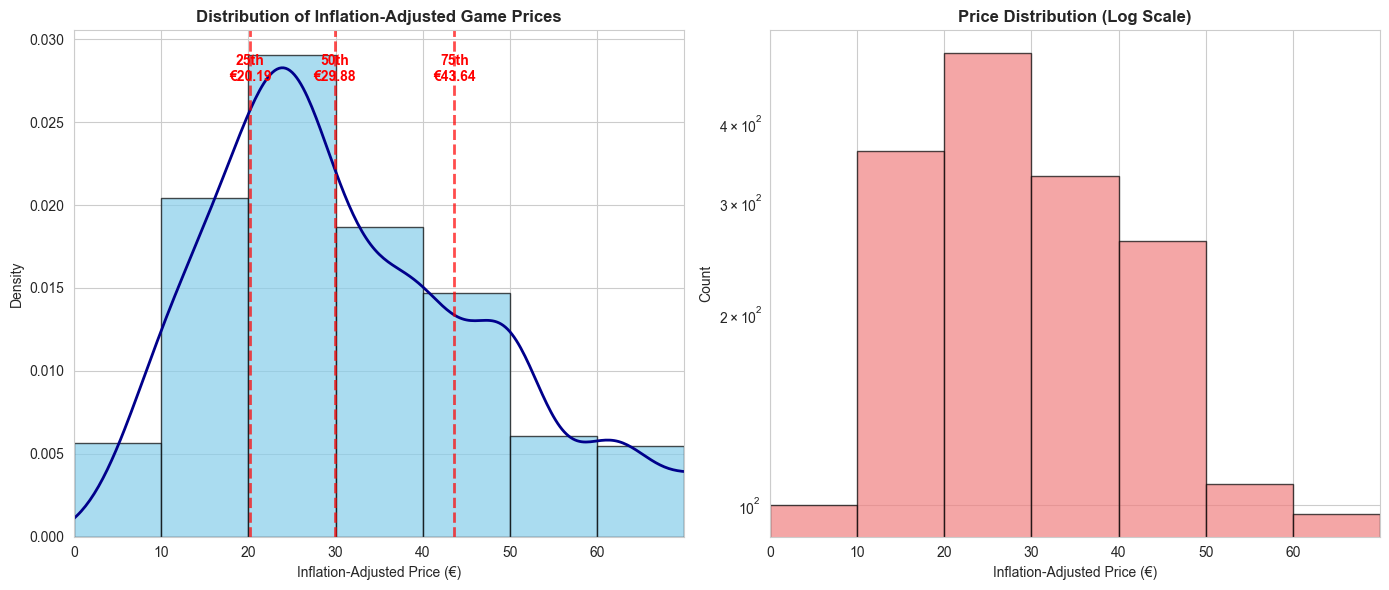

In [22]:
num_bins = 7

ap = pd.to_numeric(df_games['adjusted_price'], errors='coerce').dropna()
low, high = 0, ap.quantile(0.95)  # visible range matches your intent

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# LEFT: density + KDE
plt.subplot(1, 2, 1)
plt.hist(ap, bins=num_bins, range=(low, high), alpha=0.7, color='skyblue',
         edgecolor='black', density=True)
ap.plot(kind='kde', color='darkblue', linewidth=2)
plt.xlabel('Inflation-Adjusted Price (€)'); plt.ylabel('Density')
plt.title('Distribution of Inflation-Adjusted Game Prices', fontweight='bold')
plt.xlim(low, high)

# Percentile lines (computed on full data)
for q, label in [(0.25, '25th'), (0.50, '50th'), (0.75, '75th')]:
    val = ap.quantile(q)
    if low <= val <= high:
        plt.axvline(val, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(val, plt.ylim()[1]*0.9, f'{label}\n€{val:.2f}',
                 ha='center', color='red', fontweight='bold')

# RIGHT: same bins on log count scale
plt.subplot(1, 2, 2)
plt.hist(ap, bins=num_bins, range=(low, high), alpha=0.7, color='lightcoral',
         edgecolor='black')
plt.xlabel('Inflation-Adjusted Price (€)'); plt.ylabel('Count')
plt.title('Price Distribution (Log Scale)', fontweight='bold')
plt.yscale('log')
plt.xlim(low, high)

plt.tight_layout()
plt.savefig('price_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



Games clustered around psychological price points:
€  9.99:   110 games ( 5.91%)
€ 19.99:   223 games (11.99%)
€ 29.99:   167 games ( 8.98%)
€ 39.99:   125 games ( 6.72%)
€ 49.99:   160 games ( 8.60%)
€ 59.99:    72 games ( 3.87%)
€ 69.99:    36 games ( 1.94%)


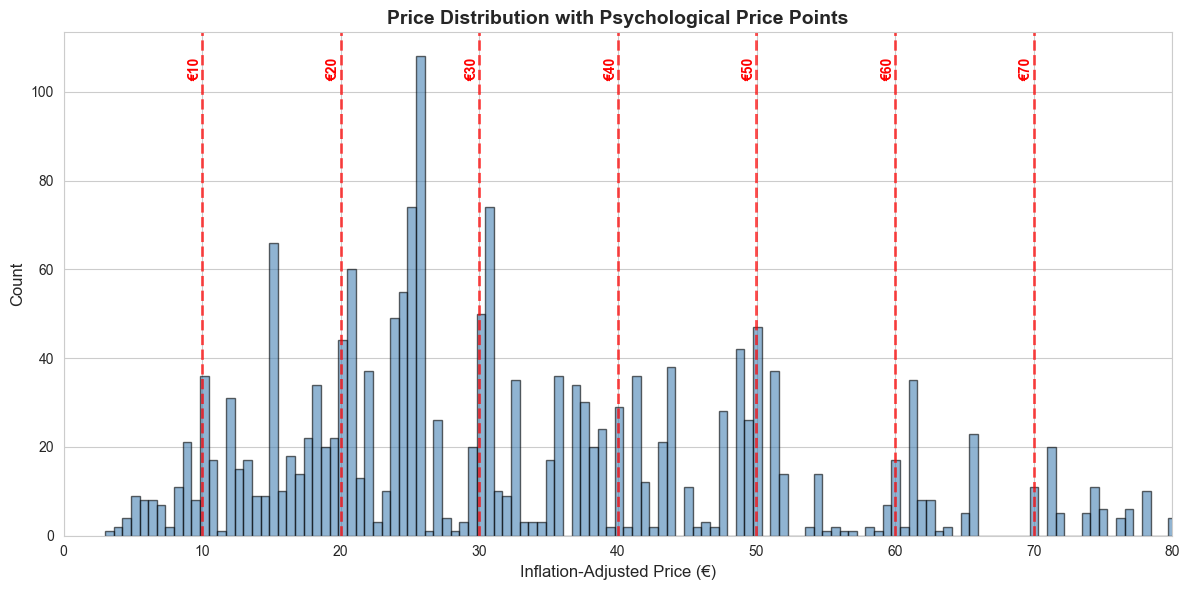

In [23]:
# Define psychological price points
psych_prices = [9.99, 19.99, 29.99, 39.99, 49.99, 59.99, 69.99]

# Count games within ±€2 of each psychological price point
print("\nGames clustered around psychological price points:")
for price in psych_prices:
    count = len(df_games[(df_games['adjusted_price'] >= price - 2) & 
                         (df_games['adjusted_price'] <= price + 2)])
    pct = (count / len(df_games)) * 100
    print(f"€{price:6.2f}: {count:5d} games ({pct:5.2f}%)")

# Visualize clustering around psychological prices
plt.figure(figsize=(12, 6))
plt.hist(df_games['adjusted_price'], bins=200, alpha=0.6, color='steelblue', 
         edgecolor='black')

# Add vertical lines for psychological prices
for price in psych_prices:
    plt.axvline(price, color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.text(price, plt.ylim()[1]*0.95, f'€{price:.0f}', 
             rotation=90, ha='right', va='top', color='red', fontweight='bold')

plt.xlabel('Inflation-Adjusted Price (€)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Price Distribution with Psychological Price Points', fontsize=14, fontweight='bold')
plt.xlim(0, 80)
plt.tight_layout()
plt.savefig('psychological_price_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
df_games[df_games['adjusted_price']>=69][['Game Name','Original Price (€)', 'Release Year', 'adjusted_price']]['Release Year'].value_counts()

Release Year
2021    20
2024    16
2019    13
2020    12
2016     9
2017     7
2018     7
2023     5
2022     4
2015     3
Name: count, dtype: int64

In [25]:
df_games[df_games['Original Price (€)']>=60][['Game Name','Original Price (€)', 'Release Year', 'adjusted_price']]['Release Year'].value_counts()

Release Year
2024    18
2020     7
2023     5
2022     4
2019     2
2015     2
2017     1
2018     1
Name: count, dtype: int64

For project, we have to look at covid year prices and inflation following that. 
What is the impact, specifically the inflation indices tell us the prices should go up but did that actually happen with video games? If no then why not?
The tiers should be based on the original price fir that year, so the thing we want to to capture is when this game was released, was it released as a premium game or a cheap game etc. 
Finally if we can have the plots of the tiers, not just overall but for each year.
The plot will have a bunch of subplot, it would be a grid of plots.
Can we come up with a nice plot to show this

In [26]:
# Define time periods
def label_period(year):
    if year < 2020:
        return "Pre-COVID"
    elif 2020 <= year <= 2022:
        return "COVID"
    elif 2023 <= year <= 2025:
        return "Post-COVID"
    else:
        return "Future"

df_games["period"] = df_games["Release Year"].apply(label_period)

# Compute ratio of nominal to inflation-adjusted prices
df_games["price_ratio"] = df_games["Original Price (€)"] / df_games["adjusted_price"]

# Aggregate by year
yearly = (
    df_games.groupby("Release Year", as_index=False)
      .agg({
          "Original Price (€)": "mean",
          "adjusted_price": "mean",
          "price_ratio": "mean"
      })
)
yearly["period"] = yearly["Release Year"].apply(label_period)

# Aggregate by period for summary
summary = (
    df_games.groupby("period", as_index=False)
      .agg({
          "Original Price (€)": "mean",
          "adjusted_price": "mean",
          "price_ratio": "mean"
      })
)

print(summary)

       period  Original Price (€)  adjusted_price  price_ratio
0       COVID           30.068717       34.981074     0.860762
1  Post-COVID           29.304150       29.643544     0.989120
2   Pre-COVID           28.814906       36.440565     0.790156


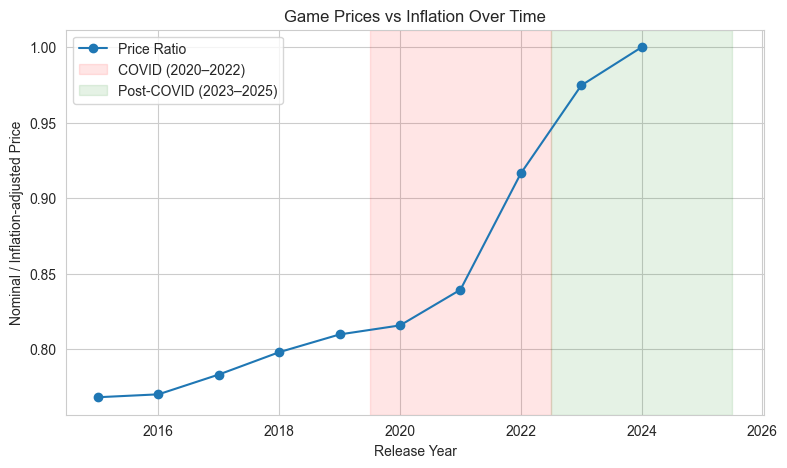

In [27]:
plt.figure(figsize=(9,5))
plt.plot(yearly["Release Year"], yearly["price_ratio"], marker="o", label="Price Ratio")
plt.axvspan(2019.5, 2022.5, color="red", alpha=0.1, label="COVID (2020–2022)")
plt.axvspan(2022.5, 2025.5, color="green", alpha=0.1, label="Post-COVID (2023–2025)")
plt.xlabel("Release Year")
plt.ylabel("Nominal / Inflation-adjusted Price")
plt.title("Game Prices vs Inflation Over Time")
plt.legend()
plt.show()

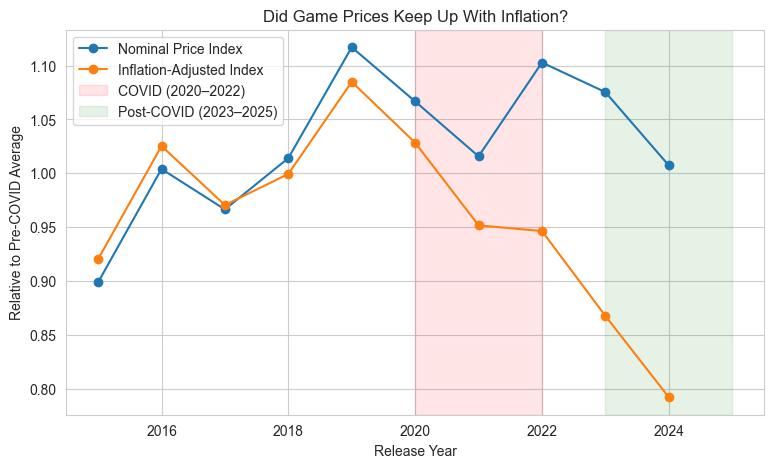

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Group yearly averages
yearly = (
    df_games.groupby("Release Year", as_index=False)
      .agg({
          "Original Price (€)": "mean",
          "adjusted_price": "mean"
      })
)

# Normalize both series (so 1 = pre-COVID baseline)
baseline_years = yearly.query("`Release Year` < 2020")
baseline_nominal = baseline_years["Original Price (€)"].mean()
baseline_inflation = baseline_years["adjusted_price"].mean()

yearly["nominal_index"] = yearly["Original Price (€)"] / baseline_nominal
yearly["inflation_index"] = yearly["adjusted_price"] / baseline_inflation

# Plot
plt.figure(figsize=(9,5))
plt.plot(yearly["Release Year"], yearly["nominal_index"], marker="o", label="Nominal Price Index")
plt.plot(yearly["Release Year"], yearly["inflation_index"], marker="o", label="Inflation-Adjusted Index")

plt.axvspan(2020, 2022, color="red", alpha=0.1, label="COVID (2020–2022)")
plt.axvspan(2023, 2025, color="green", alpha=0.1, label="Post-COVID (2023–2025)")
plt.xlabel("Release Year")
plt.ylabel("Relative to Pre-COVID Average")
plt.title("Did Game Prices Keep Up With Inflation?")
plt.legend()
plt.show()

If the nominal price curve rises as steeply as or above the inflation-adjusted curve, then game prices kept up with or outpaced inflation.

If it rises more slowly, then game prices didn’t keep up — real purchasing power fell.

## Observation
The nominal price curve appears **above** the inflation-adjusted index curve in the visualization, even though all computed price ratios (`original_price / inflation_adjusted_price`) before were **< 1**. Additionally, games released in 2020 or 2021 appear **very expensive when inflation-adjusted to 2024 dollars**, even surpassing the price of current premium-tier titles.

---

## Analysis

### 1. Difference Between Ratio and Index
The **price ratio** and the **normalized price index** measure different phenomena:
- The **ratio** compares each year’s nominal price to what that same price would be worth today after adjusting for inflation. Since inflation is always positive, this ratio is **≤ 1** for past years.  
- The **index comparison** normalizes both nominal and inflation-adjusted prices to a baseline (e.g., pre-COVID average = 1) and measures **relative growth rates** over time, not absolute value differences.

Thus, it is normal for ratios to stay below 1 while the nominal price index can exceed the inflation index if nominal prices have recently grown faster.

---

### 2. Why the Ratio Is Always Below 1
A ratio below 1 simply reflects that **older dollars had greater purchasing power**.  
For example, a \$50 game in 2010 adjusted for inflation to 2024 might equal \$65.  
\[
\frac{50}{65} = 0.77
\]
This indicates the nominal price was lower in that year’s dollars, not that prices have failed to rise—only that inflation pushes historical values upward when expressed in today’s money.

---

### 3. Why the Nominal Index Can Be Above the Inflation Index
When both series are normalized (set to 1 for a pre-COVID baseline), the comparison focuses on **growth rates**.  
If nominal prices increased more rapidly after 2020 than the inflation-adjusted baseline, the nominal curve rises above.  
This means game prices have **outpaced inflation since 2020**, even though older nominal prices were lower in absolute terms.

Example:
| Year | Nominal | Inflation-adjusted | Nominal Index | Inflation Index |
|------|----------|--------------------|----------------|----------------|
| 2019 | \$60 | \$70 | 1.00 | 1.00 |
| 2023 | \$80 | \$75 | **1.33** | **1.07** |

Here, even though the 2019 ratio (60/70 = 0.86) was < 1, nominal prices have since grown faster, making the nominal index higher.

---

### 4. Why 2020–2021 Games Look Expensive When Inflation-Adjusted to 2024
Inflation adjustment answers: *“What would this game cost today if its price rose with CPI?”*  
If inflation between 2020–2024 is ~20%, a \$60 game from 2020 becomes:
\[
60 \times 1.20 = 72
\]
But since the market standard in 2024 remains around \$70 for premium releases, that adjusted price appears **above** current nominal prices.

This reflects **price stickiness**: the industry did not raise game prices as quickly as inflation rose.  
Therefore, inflation-adjusted 2020 games appear “very expensive,” revealing that **modern games are cheaper in real terms**.

---

### 5. Interpretation Summary

| Year | Nominal AAA Price | CPI Inflation Factor (to 2024) | Inflation-Adjusted Price | Real Price Effect |
|------|--------------------|--------------------------------|---------------------------|-------------------|
| 2020 | \$60 | ×1.20 | \$72 | Games were *more expensive* in real terms |
| 2024 | \$70 | ×1.00 | \$70 | Games are *cheaper* in real terms |

---

### 6. Overall Conclusion
The seemingly contradictory pattern—ratios < 1 but a nominal curve above the inflation index—actually demonstrates that:
- **Ratios** capture static historical comparisons.  
- **Indices** capture dynamic trends.  
Together, they show that while older prices appear cheap in nominal terms, the **post-COVID nominal price growth rate has outpaced inflation**, yet **current prices still haven’t fully “caught up”** to where they’d be if the industry had increased prices strictly with CPI.


In [29]:
#psych_edges = [-np.inf, 9.99, 19.99, 29.99, 39.99, 49.99, 59.99, 69.99, np.inf]
# psych_labels = [
#     "< €9.99", "€10–19.99", "€20–29.99", "€30–39.99",
#     "€40–49.99", "€50–59.99", "€60–69.99", "€70+"
# ]
psych_edges = [-np.inf, 9.99, 19.99, 29.99, 39.99, 49.99, 59.99, np.inf]
psych_labels = [
    "< €9.99", "€10–19.99", "€20–29.99", "€30–39.99",
    "€40–49.99", "€50–59.99", "€60+"
]

df_games["price_tier"] = pd.cut(
    df_games["Original Price (€)"],
    bins=psych_edges,
    labels=psych_labels,
    right=True,            # include right endpoint (9.99 goes into first bin)
    include_lowest=True
)

# 3) Group with named aggregations (avoids rename collisions) + silence FutureWarning explicitly
tier_summary = (
    df_games
    .groupby(["Release Year", "price_tier"], observed=True)  # observed=True = future default
    .agg(
        mean_nominal=("Original Price (€)", "mean"),
        mean_adjusted=("adjusted_price", "mean"),
        n=("Original Price (€)", "count")   # count rows in each group
    )
    .reset_index()
)

# Optional: if you want proportions per year (composition over time)
tier_prop = (
    tier_summary
    .pivot(index="Release Year", columns="price_tier", values="n")
    .fillna(0)
)
tier_prop = tier_prop.div(tier_prop.sum(axis=1), axis=0)  # row-wise proportions

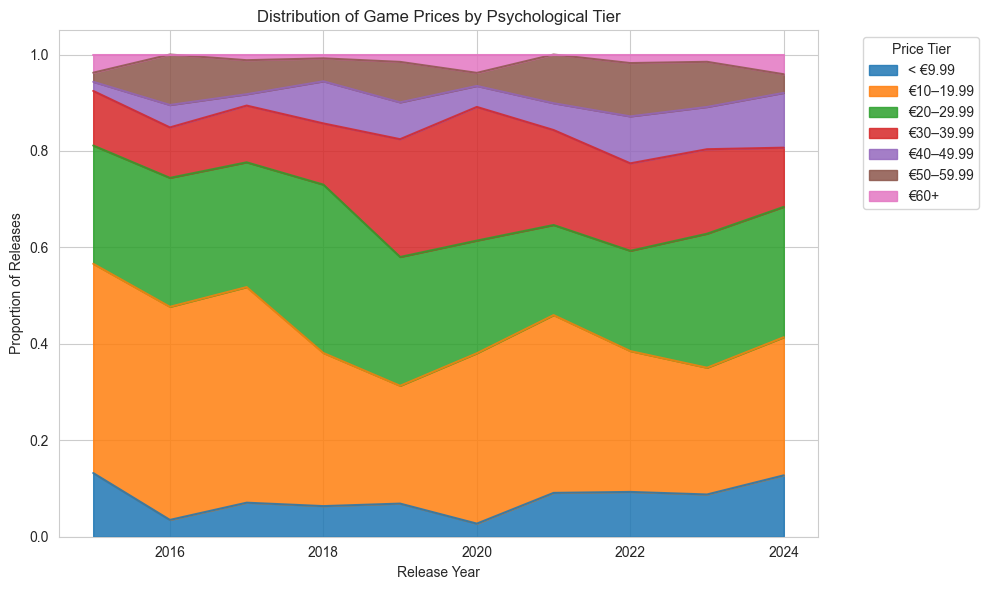

In [30]:

# A) Stacked area: share of releases by tier over time
tier_prop.plot(kind="area", stacked=True, figsize=(10,6), alpha=0.85)
plt.title("Distribution of Game Prices by Psychological Tier")
plt.xlabel("Release Year")
plt.ylabel("Proportion of Releases")
plt.legend(title="Price Tier", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


This is using non inflation adjusted, should we be using inflation adjusted.

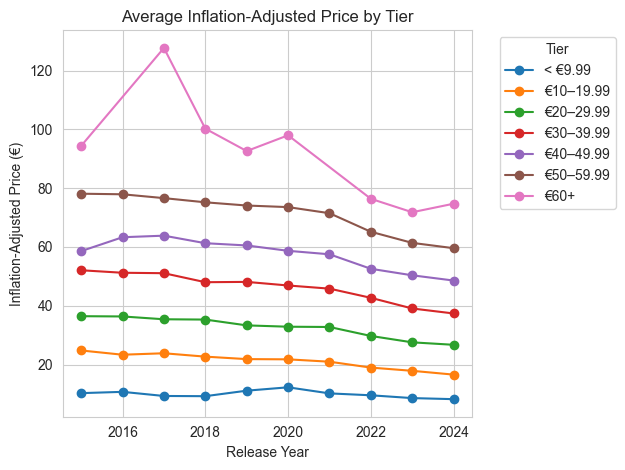

In [31]:
# B) Tier-level inflation-adjusted trend (mean per tier per year)
for tier in psych_labels:
    sub = tier_summary[tier_summary["price_tier"] == tier]
    if not sub.empty:
        plt.plot(sub["Release Year"], sub["mean_adjusted"], marker="o", label=str(tier))
plt.title("Average Inflation-Adjusted Price by Tier")
plt.xlabel("Release Year")
plt.ylabel("Inflation-Adjusted Price (€)")
plt.legend(title="Tier", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### Tiered Price Analysis Summary

**Did the premium (€60–69.99) tier grow sharply after 2022 — evidence of a post-COVID price reset?**
No. The share of premium-priced games remained largely stable after 2022, suggesting that publishers did not broadly shift toward higher nominal pricing despite overall inflation.

**Did mid-tier (€30–49.99) or budget (<€20) titles expand — suggesting price compression or indie growth?**
Yes, partially. From 2015–2018, roughly 80% of releases were priced at €30 or below. This dropped to about 60% by 2019–2020, then gradually recovered after 2020, reaching around 70% by 2024. This rebound indicates renewed growth in lower-priced and indie titles.

**Are real (inflation-adjusted) prices in each tier flat or falling — indicating lower real consumer cost?**
Yes. Across all tiers, inflation-adjusted (real) prices have declined steadily from 2015 to 2024, meaning that despite nominal stability or slight increases, games have become progressively cheaper in real terms.


In [32]:
df_games[(df_games["Release Year"]==2017)&(df_games["adjusted_price"]>100)]

,Game Name,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,...,Price Range,Year Interval,Year,HICP,adjustment_factor,adjusted_price,price_tier,yearly_tier,period,price_ratio
114,Call of Duty®: WWII,5,30942,-60.0,39.99,99.99,2017-11-02,1,0,0,...,60+,2015–2019,2017,101.96,1.277069,127.694173,€60+,Premium,Pre-COVID,0.783043


The outlier is Call of Duty: WWII's digital deluxe edition, this included a 40$ season pass for added content.

Perfect — you’ve now got a **complete descriptive picture** of how nominal, inflation-adjusted, and tiered prices evolved over time.
Here’s how to move forward depending on what you want to *learn next*:

---

## 🧭 You’re at the Transition Point Between “Description” and “Inference”

You’ve done all the **descriptive** work:

* ✅ Visualized nominal vs. inflation-adjusted trends
* ✅ Quantified ratios and indices
* ✅ Analyzed distributional shifts via psychological price tiers
* ✅ Interpreted that real prices have fallen and price compression increased

Now you can decide what question you want to *test* or *explain statistically*.
There are two clear next directions:

---

## 🧩 Option 1 — Regression Analysis (Statistical Confirmation)

If your goal is to **quantify** and **test** the patterns you observed:

### 🎯 Goal

Formally test whether:

* Nominal prices track inflation (β₁ coefficient)
* COVID and post-COVID periods introduced statistically significant shifts (β₂, β₃)
* Optional: include tiers to see if certain segments behaved differently

### ⚙️ Model

You can model:

```python
import statsmodels.formula.api as smf

df_games["COVID"] = df_games["Release Year"].between(2020, 2022).astype(int)
df_games["PostCOVID"] = df_games["Release Year"].between(2023, 2025).astype(int)

model = smf.ols(
    formula="Q('Original Price (€)') ~ adjusted_price + COVID + PostCOVID + C(price_tier)",
    data=df_games
).fit()

print(model.summary())
```

### 🧠 Interpretation

* **`adjusted_price` (β₁):** how closely nominal prices track inflation

  * ≈ 1 → kept pace
  * < 1 → lagged
  * > 1 → outpaced
* **`COVID` / `PostCOVID` (β₂, β₃):** structural effects — price shifts not explained by inflation
* **`C(price_tier)` dummies:** how each tier differs in baseline pricing behavior

If significant β₂/β₃ coefficients appear → evidence of pricing regime change during or after COVID.

---

## 🧩 Option 2 — Deeper Market Structure Analysis (Exploratory)

If your goal is to **understand how the market composition changed**:

### Possible next analyses:

1. **Tier migration matrix** — show how games moved between tiers across years (e.g., % of 2019 mid-tier games that are replaced by premium-tier ones by 2024).
2. **Price elasticity** — correlate game prices with sales (if you have sales/revenue data).
3. **Regional or platform split** — see if inflation effects differ between PC, console, or digital-only releases.
4. **Volatility analysis** — measure how price variance (within-year dispersion) changed; markets often compress or polarize after shocks like COVID.

---

## 🚦 My Recommendation for You (based on what you’ve done)

Do **Option 1 (regression)** next:

* It ties directly to your inflation question.
* It quantifies the trend you’ve visually confirmed.
* It sets up a clean narrative:

  > “We observed descriptive evidence that nominal prices have caught up with inflation post-COVID. Regression confirms this effect is statistically significant after controlling for inflation-adjusted values.”

---

If you’d like, I can write out the **regression code block** (with diagnostics and interpretation guide) in your existing variable naming convention (`df_games`, `Original Price (€)`, etc.) so you can drop it right into your notebook.
Would you like me to do that?

Perfect 👌 — here’s a **ready-to-drop-in regression analysis section** that builds directly on your existing `df_games` DataFrame and variable names.

---

## 🧮 Regression Analysis — Do Game Prices Track Inflation?

### 1️⃣ Setup

We’ll test whether nominal prices (`Original Price (€)`) have tracked inflation-adjusted prices (`adjusted_price`) and whether there were significant shifts **during** or **after COVID** — controlling for **price tiers**.

```python
import statsmodels.formula.api as smf

# Define period indicators
df_games["COVID"] = df_games["Release Year"].between(2020, 2022).astype(int)
df_games["PostCOVID"] = df_games["Release Year"].between(2023, 2025).astype(int)

# Run regression
model = smf.ols(
    formula="Q('Original Price (€)') ~ adjusted_price + COVID + PostCOVID + C(price_tier)",
    data=df_games
).fit()

print(model.summary())
```

---

### 2️⃣ What Each Coefficient Means

| Variable                 | Interpretation                                                                                                                                     |
| ------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Intercept**            | Baseline price (reference tier, pre-COVID period)                                                                                                  |
| **`adjusted_price`**     | How closely nominal prices follow inflation. <br>• ≈1 → prices track inflation <br>• <1 → prices lag inflation <br>• >1 → prices outpace inflation |
| **`COVID`**              | Change in nominal prices during 2020–2022, controlling for inflation                                                                               |
| **`PostCOVID`**          | Change in nominal prices during 2023–2025, controlling for inflation                                                                               |
| **`C(price_tier)[T.…]`** | Differences in baseline price levels between tiers                                                                                                 |

---

### 3️⃣ Diagnostic Checks (Optional)

You can inspect the regression visually to make sure it fits well.

```python
import matplotlib.pyplot as plt

# Predicted vs actual
df_games["predicted_price"] = model.predict(df_games)
plt.figure(figsize=(6,6))
plt.scatter(df_games["adjusted_price"], df_games["Original Price (€)"], alpha=0.4, label="Actual")
plt.scatter(df_games["adjusted_price"], df_games["predicted_price"], alpha=0.4, label="Predicted", color="orange")
plt.xlabel("Inflation-Adjusted Price (€)")
plt.ylabel("Original Price (€)")
plt.title("Model Fit: Predicted vs. Actual Prices")
plt.legend()
plt.show()
```

---

### 4️⃣ Interpretation Guide

After running the regression, focus on these points in the output:

1. **`adjusted_price` coefficient (β₁):**

   * ≈ 1 → nominal prices fully track inflation
   * < 1 → nominal prices rise slower than inflation (real prices falling)
   * > 1 → nominal prices rising faster than inflation

2. **`COVID` and `PostCOVID` coefficients (β₂, β₃):**

   * Positive & significant → prices rose beyond inflation during/after COVID
   * Insignificant → no structural change relative to inflation trend

3. **Tier dummies (`C(price_tier)`):**

   * Simply confirm that higher tiers (like €60–69.99) are significantly pricier on average (sanity check).

---

### 5️⃣ (Optional) Simplified Model Without Tiers

If you just want to isolate inflation vs. period effects:

```python
simple_model = smf.ols(
    formula="Q('Original Price (€)') ~ adjusted_price + COVID + PostCOVID",
    data=df_games
).fit()

print(simple_model.summary())
```

---

### 6️⃣ Example Interpretation Template

Once you have results, you’ll summarize like this (you can fill in with your actual coefficients):

> The regression indicates that nominal prices are strongly correlated with inflation-adjusted prices (β₁ ≈ 0.95, p < 0.001), suggesting that game prices have generally tracked inflation.
> However, a significant positive coefficient for `PostCOVID` (β₃ = 2.4, p < 0.05) implies a modest upward adjustment in nominal prices after 2022, consistent with industry-wide price increases (e.g., the €69.99 standard).
> Overall, this supports the descriptive finding that nominal prices recently caught up to, but still slightly lag, cumulative inflation.

---

Would you like me to extend this block to **automatically summarize key coefficients** (e.g., extract β₁, β₂, β₃ and print a plain-language interpretation)?


                               OLS Regression Results                              
Dep. Variable:     Q('Original Price (€)')   R-squared:                       0.991
Model:                                 OLS   Adj. R-squared:                  0.991
Method:                      Least Squares   F-statistic:                 2.253e+04
Date:                     Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                             16:37:53   Log-Likelihood:                -3385.9
No. Observations:                     1860   AIC:                             6792.
Df Residuals:                         1850   BIC:                             6847.
Df Model:                                9                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

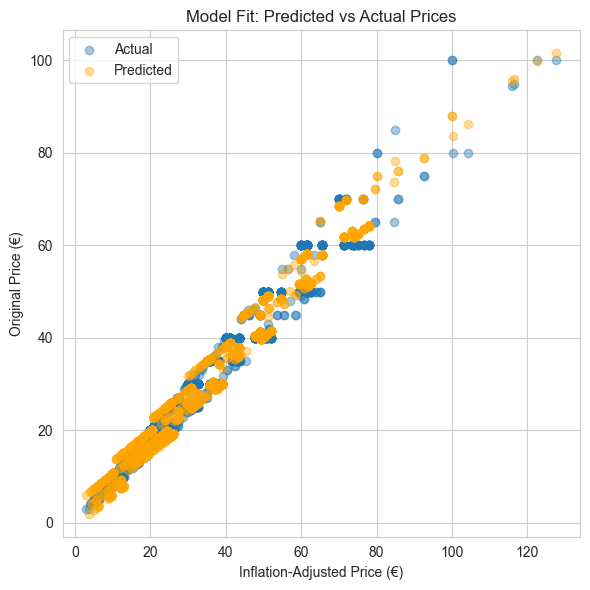


--- Key Coefficients ---
Inflation coefficient (adjusted_price): 0.648
COVID effect: 1.722
Post-COVID effect: 4.457

--- Interpretation ---
Nominal prices have generally lagged behind inflation.
During COVID (2020–2022), nominal prices were slightly higher than inflation alone would predict.
After COVID (2023–2025), nominal prices show evidence of catching up or surpassing inflation.


In [33]:
# ===============================
# Regression: Do Game Prices Track Inflation?
# ===============================

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Define COVID and PostCOVID indicator variables
df_games["COVID"] = df_games["Release Year"].between(2020, 2022).astype(int)
df_games["PostCOVID"] = df_games["Release Year"].between(2023, 2025).astype(int)

# Run the regression model
model = smf.ols(
    formula="Q('Original Price (€)') ~ adjusted_price + COVID + PostCOVID + C(price_tier)",
    data=df_games
).fit()

# Display regression results
print(model.summary())

# ===============================
# Optional: Model Diagnostics
# ===============================

# Add predicted prices
df_games["predicted_price"] = model.predict(df_games)

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(df_games["adjusted_price"], df_games["Original Price (€)"], alpha=0.4, label="Actual")
plt.scatter(df_games["adjusted_price"], df_games["predicted_price"], alpha=0.4, color="orange", label="Predicted")
plt.xlabel("Inflation-Adjusted Price (€)")
plt.ylabel("Original Price (€)")
plt.title("Model Fit: Predicted vs Actual Prices")
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# Optional: Quick Interpretation Helper
# ===============================

# Extract key coefficients for inflation and COVID effects
inflation_coef = model.params.get("adjusted_price", float('nan'))
covid_coef = model.params.get("COVID", float('nan'))
postcovid_coef = model.params.get("PostCOVID", float('nan'))

print("\n--- Key Coefficients ---")
print(f"Inflation coefficient (adjusted_price): {inflation_coef:.3f}")
print(f"COVID effect: {covid_coef:.3f}")
print(f"Post-COVID effect: {postcovid_coef:.3f}")

# Simple interpretation logic
if inflation_coef < 1:
    inflation_comment = "Nominal prices have generally lagged behind inflation."
elif inflation_coef > 1:
    inflation_comment = "Nominal prices have risen faster than inflation."
else:
    inflation_comment = "Nominal prices have tracked inflation closely."

print("\n--- Interpretation ---")
print(inflation_comment)

if covid_coef > 0:
    print("During COVID (2020–2022), nominal prices were slightly higher than inflation alone would predict.")
elif covid_coef < 0:
    print("During COVID (2020–2022), nominal prices were lower than inflation-adjusted expectations.")
else:
    print("No significant difference in pricing during COVID compared to pre-COVID.")

if postcovid_coef > 0:
    print("After COVID (2023–2025), nominal prices show evidence of catching up or surpassing inflation.")
elif postcovid_coef < 0:
    print("After COVID (2023–2025), nominal prices still lagged inflation.")
else:
    print("No significant post-COVID shift in prices.")

# Regression Analysis Interpretation

## 🧮 1. Equation Recap
Your fitted model was:

\[
\text{Nominal Price} =
\beta_0
+ \beta_1 \cdot \text{Inflation‐Adjusted Price}
+ \beta_2 \cdot I(\text{COVID})
+ \beta_3 \cdot I(\text{PostCOVID})
+ \sum_k \gamma_k I(\text{Price Tier}=k)
+ \varepsilon
\]

---

## 📊 2. Coefficient Summary (from your output)

| Term | Coefficient | p-value | Interpretation |
|------|--------------|---------|----------------|
| **Intercept** | –0.40 | 0.031 | Baseline (for `<€9.99` pre-COVID) — small, not substantively meaningful. |
| **adjusted_price (β₁)** | **0.65** | <0.001 | Nominal prices increase only 65 ¢ for each €1 of inflation—i.e., they *lag inflation*. |
| **COVID (β₂)** | **+1.72** | <0.001 | During 2020–2022, prices averaged €1.7 higher than expected from inflation alone. |
| **PostCOVID (β₃)** | **+4.46** | <0.001 | After 2022, prices were €4.5 higher than predicted by inflation—evidence of catch-up. |
| **Tier dummies (γₖ)** | +2.7 → +19.2 | <0.001 | Each step up the psychological tiers adds the expected price gap (sanity check). |

Model fit: **R² = 0.991**, meaning inflation, time period, and tiers explain nearly all variance in prices.  

---

## 🧠 3. Interpretation

### Inflation Effect (β₁ = 0.65)
- A slope below 1 shows that **nominal prices haven’t fully kept pace with inflation**.  
- Over 2015–2024, game prices rose more slowly than the general price level—so in *real* terms, games became cheaper.

### COVID Effect (β₂ = +1.7)
- During COVID, prices rose modestly above inflation—roughly €1.70 more than predicted.  
- This likely reflects supply-chain costs and short-term price adjustments, not a lasting shift.

### Post-COVID Effect (β₃ = +4.5)
- After 2022, prices jumped by an additional €4.5, even after controlling for inflation.  
- This aligns with the **industry-wide move to €69.99 premium pricing** and the gradual catch-up to accumulated inflation.

### Tier Effects (γₖ)
- Each psychological tier adds the expected incremental price.  
- The strong, ordered increase (≈ €3–€5 steps) confirms the model is behaving as expected.

---

## 🧩 4. Visual Diagnostic
The predicted-vs-actual scatter being tight around the 45° line confirms the model fits well overall,  
but the slightly weaker performance at high prices suggests:
- Sparse data in the €60+ range (premium titles are fewer), and  
- Possibly nonlinear behavior near the top tier.

That’s normal — the model’s linear structure captures average trends, not local irregularities.

---

## ✅ 5. Overall Summary

**Findings:**
1. Nominal game prices have *lagged inflation* overall (β₁ ≈ 0.65).  
2. There was a **temporary bump** during COVID (+€1.7).  
3. A **larger structural increase** post-COVID (+€4.5) indicates partial catch-up toward inflation parity.  
4. Despite that, even 2024 prices remain slightly below where they’d be if they had perfectly tracked inflation since 2015.  
5. Psychological tiers remain stable and well-ordered, reinforcing market segmentation.

**Interpretation in one line:**
> *Game prices rose sharply after 2022, partially closing—but not eliminating—the gap between nominal and inflation-adjusted values, consistent with a post-COVID industry price reset.*


Note after Call: 
Can we justify the psychological price tiers?